## Fresh notebook for using `halotools` on PDR catalog 

In [2]:
from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits
from astropy import units as u
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'stixgeneral'
%matplotlib inline
#matplotlib.matplotlib_fname()
#import linetools.utils as ltu
from astropy.coordinates import Angle
from astropy.coordinates import SkyCoord
import copy
from colossus.halo import profile_nfw
%config InlineBackend.figure_format = 'retina'

In [10]:
# read in the data
data_pth = '/Users/astro/Desktop/GitHub/satellite_fraction/data/'
data_file = data_pth + 's16a_massive_logmMax_11.45_z_0.25_0.47_mhalo.fits'

hdu1 = fits.open(data_file)
data_table = Table(hdu1[1].data)

# set cosmology params
import colossus
from colossus.cosmology import cosmology
params = {'flat': True , 'H0': 70.0 , 'Om0': 0.3 , 'Ob0': 0.049, 'sigma8': 0.81, 'ns': 0.95}
h = .7
cosmology.addCosmology('huang18',params)
cosmology.setCosmology('huang18')
from colossus.halo import mass_so

# cut the table
pdr_use = Table(names = data_table.colnames)

for i in range(len(np.array(data_table['logm_max']))):
    if data_table['logm_max'][i] > 11.5 and data_table['z_best'][i] > .25 and data_table['z_best'][i] < .45:
        pdr_use.add_row(data_table[i])
        
# get rid of two bad galaxies
pdr_use.remove_row(np.where(pdr_use['ra'] == 33.121181211450285)[0][0])
pdr_use.remove_row(np.where(pdr_use['ra'] == 333.7062012551158)[0][0])

# define mass bin edges
mass_bins = [11.5,11.6,11.7,11.8,11.9,12.0,12.2,np.max(pdr_use['logm_max'])]


### Now try getting he PDR data curve. `halotools` doesn't like our coordinates (ra, dec, z), so I'll write my own (similar) function

In [11]:
def pdr_pairs(i, j, in_table, z_lim, parent_table): 
    
    # the object we choose here is going to be a central by the way we have defined things
    cent_gal = in_table[i]

    
    # this was a trick that song used to make a new catalog for the other objects of interest.
    # the utility is that we don't have to loop through the whole catalog EVERY TIME
    cat_use = copy.deepcopy(parent_table[(parent_table['logm_max'] > mass_bins[j+1])])
    
    
    # find the galaxies within the delta z limit
    dz = cat_use[np.abs(cent_gal['z_best'] - cat_use['z_best']) <= z_lim]
    
    pair_index = [] # list of indices of objects within cylinder
    
    if len(dz) > 0:
        # find separation for gals within dz
        dz['sep'] = SkyCoord(cent_gal['ra']*u.deg, cent_gal['dec']*u.deg).separation(SkyCoord(dz['ra']*u.deg, dz['dec']*u.deg)).degree 
    for i in range(len(dz)):
        if dz['sep'][i] <= cent_gal['r_vir']:
            pair_index.append(dz['index'][i])
            
    num_pairs = len(pair_index)
    
    return(num_pairs) # need the normalization factor for later. Length of the threshold sample

In [12]:
# useful quantities
pdr_use['index'] = np.zeros(len(pdr_use['logm_max']))
for i in range(len(pdr_use['index'])):
    pdr_use['index'][i] = i

# Now to find r_halo
r_halo = mass_so.M_to_R((10**pdr_use['logmh_vir'])*h , pdr_use['z_best'], 'vir')/h #kpc

# Turn the physical radius into an angular size in degrees
theta_per_kpc = FlatLambdaCDM(H0=70 , Om0= 0.3).arcsec_per_kpc_proper(pdr_use['z_best'])
pdr_use['r_vir'] = ((r_halo*u.kpc * theta_per_kpc).to(u.deg))/u.deg

In [13]:
# attempt to clean up the process
mass_binned_tables = [Table(names = pdr_use.colnames), Table(names = pdr_use.colnames), 
                      Table(names = pdr_use.colnames), Table(names = pdr_use.colnames),
                      Table(names = pdr_use.colnames), Table(names = pdr_use.colnames),
                      Table(names = pdr_use.colnames)]

for i in range(len(pdr_use)):
    if pdr_use['logm_max'][i] > 11.5 and pdr_use['logm_max'][i] < 11.6:
        mass_binned_tables[0].add_row(pdr_use[i])
    if pdr_use['logm_max'][i] > 11.6 and pdr_use['logm_max'][i] < 11.7:
        mass_binned_tables[1].add_row(pdr_use[i])
    if pdr_use['logm_max'][i] > 11.7 and pdr_use['logm_max'][i] < 11.8:
        mass_binned_tables[2].add_row(pdr_use[i])
    if pdr_use['logm_max'][i] > 11.8 and pdr_use['logm_max'][i] < 11.9:
        mass_binned_tables[3].add_row(pdr_use[i])
    if pdr_use['logm_max'][i] > 11.9 and pdr_use['logm_max'][i] < 12.0:
        mass_binned_tables[4].add_row(pdr_use[i])
    if pdr_use['logm_max'][i] > 12.0 and pdr_use['logm_max'][i] < 12.2:
        mass_binned_tables[5].add_row(pdr_use[i])
    if pdr_use['logm_max'][i] > 12.2:
        mass_binned_tables[6].add_row(pdr_use[i])
        


In [14]:
counts = [[], [], [], [], [], []] # empty array to populate with counts
# now actually do CiC
for i in range(6):
    for j in range(len(mass_binned_tables[i])):
        counts[i].append(pdr_pairs(j, i, mass_binned_tables[i], .008, pdr_use))

In [15]:
total_counts = []
for i in range(len(counts)):
    total_counts.append(sum(counts[i]))
total_counts

[127, 56, 20, 5, 1, 0]

<Container object of 3 artists>

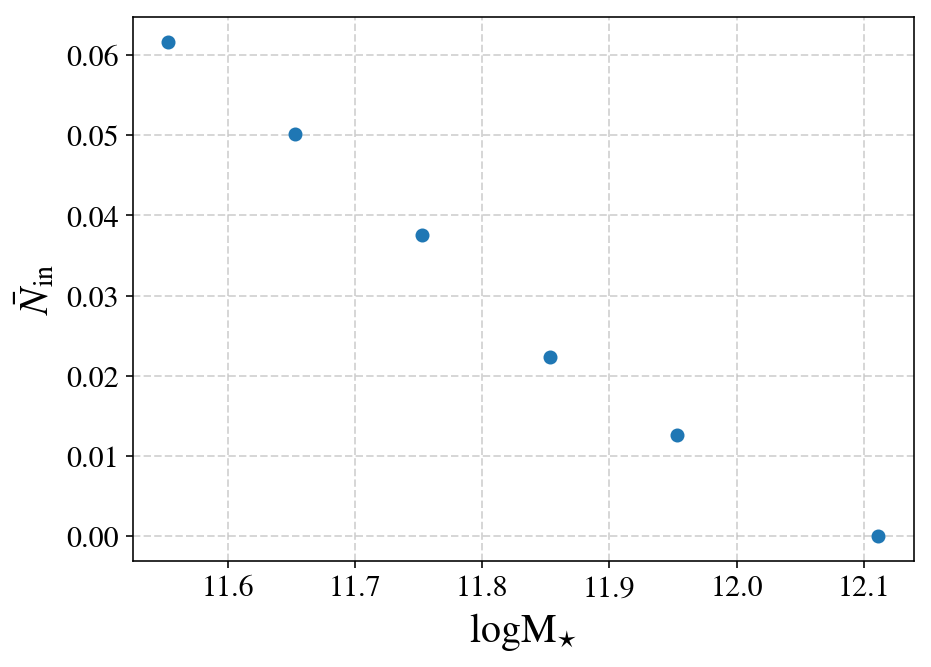

In [16]:
bins = [0,1,2,3,4,5,6,7]
hist_11_5, edges_11_5 = np.histogram(counts[0],bins)
hist_11_6, edges_11_6 = np.histogram(counts[1],bins)
hist_11_7, edges_11_7 = np.histogram(counts[2],bins)
hist_11_8, edges_11_8 = np.histogram(counts[3],bins)
hist_11_9, edges_11_9 = np.histogram(counts[4],bins)
hist_12_0, edges_12_0 = np.histogram(counts[5],bins)


mean_11_5 = (0*hist_11_5[0] + 1*hist_11_5[1] + 2*hist_11_5[2] + 3*hist_11_5[3])/sum(hist_11_5)
mean_11_6 = (0*hist_11_6[0] + 1*hist_11_6[1] + 2*hist_11_6[2])/sum(hist_11_6)
mean_11_7 = (0*hist_11_7[0] + 1*hist_11_7[1] + 2*hist_11_7[2])/sum(hist_11_7)
mean_11_8 = (0*hist_11_8[0] + 1*hist_11_8[1] + 2*hist_11_8[2])/sum(hist_11_8)
mean_11_9 = (0*hist_11_9[0] + 1*hist_11_9[1] + 2*hist_11_9[2])/sum(hist_11_9)
mean_12_0 = (0*hist_12_0[0] + 1*hist_12_0[1] + 2*hist_12_0[2])/sum(hist_12_0)

means = [mean_11_5, mean_11_6, mean_11_7, mean_11_8, mean_11_9, mean_12_0]

err = [np.sqrt(sum(hist_11_5))/sum(hist_11_5),
      np.sqrt(sum(hist_11_6))/sum(hist_11_6),
      np.sqrt(sum(hist_11_7))/sum(hist_11_7),
      np.sqrt(sum(hist_11_8))/sum(hist_11_8),0,0]
#      np.sqrt(sum(hist_11_9))/sum(hist_11_9),
#      np.sqrt(sum(hist_12_0))/sum(hist_12_0),
#      np.sqrt(sum(hist_12_1))/sum(hist_12_1),
#      np.sqrt(sum(hist_12_2))/sum(hist_12_2)]

# where to plot the points. Mean mass in the bin
mass_bins = [11.5,11.6,11.7,11.8,11.9,12.0,12.2]
hist, edges = np.histogram(pdr_use['logm_max'],mass_bins)
mass_mean = np.log10((10**(edges[1:]) + 10**(edges[:-1])) / 2)
mass_mean


fig = plt.figure(figsize = [7,5])
ax1 = fig.add_subplot(111)
ax1.grid(linewidth=1, linestyle='--', alpha=0.5)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)

ax1.set_ylabel(r'$ \bar{N}_{\rm in}$', fontsize = 20)
ax1.set_xlabel(r'$\log \rm M_{\star}$', fontsize = 20)
ax1.errorbar(mass_mean, means, fmt = 'o')

## Test CiC against UM data

In [17]:
um_file = data_pth + 'um_ins_exs_logms_10.8_asap_180813_vel.fits'
um_table = Table((fits.open(um_file)[1]).data)
um_use = um_table[um_table['logms_tot']>11.5]

In [18]:
# set up data

from halotools.mock_observables import apply_zspace_distortion
from astropy.cosmology import Planck15 as cosmo # um uses planck cosmology
z_dis = apply_zspace_distortion(um_use['z'], um_use['vz'], .37, cosmo, 400.0)
um_use['z_dist'] = z_dis
h=.7
# get rid of h in spatial coords
um_use['z_dist'] = um_use['z_dist']/h
um_use['x'] = um_use['x']/h
um_use['y'] = um_use['y']/h

# get virial radii
mvir = um_use['logmh_vir']

# m_to_r use 'vir' definition
r_h = mass_so.M_to_R((10**mvir)*h , .37, 'vir') * 1e-3 #Mpc/h

um_use['r_vir'] = (r_h / h) * (1.37) #comoving Mpc

# Make an index column
um_use['index'] = np.zeros(len(um_use['logms_max']))
for i in range(len(um_use['index'])):
     um_use['index'][i] = i
        
        
um_use.sort('logms_max')
um_use.reverse()

/Users/astro/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [30]:
def um_pairs(i, j, in_table, l_lim): 
    
    # the object we choose here is going to be a central by the way we have defined things
    cent_gal = in_table[i]

    
    # this was a trick that song used to make a new catalog for the other objects of interest.
    # the utility is that we don't have to loop through the whole catalog EVERY TIME
    cat_use = copy.deepcopy(um_use[(um_use['logms_max'] > mass_bins[j+1])])
    
    
    # find the galaxies within the delta z limit
    delta_l_cut = cat_use[np.abs(cent_gal['z_dist'] - cat_use['z_dist']) <= l_lim]
    
    pair_index = [] # list of indices of objects within cylinder
    
    if len(delta_l_cut) > 0:
        # find separation for gals within dl (x-y dist)
        delta_l_cut['sep'] = np.sqrt( ((delta_l_cut['x'] - cent_gal['x'])**2) + ((delta_l_cut['y'] - cent_gal['y'])**2) )

    for i in range(len(delta_l_cut)):
        if delta_l_cut['sep'][i] <= cent_gal['r_vir']:
            pair_index.append(delta_l_cut['index'][i])
            
    num_pairs = len(pair_index)
    
    return(num_pairs)

In [21]:
# attempt to clean up the process
um_tables = [Table(names = um_use.colnames), Table(names = um_use.colnames), 
                      Table(names = um_use.colnames), Table(names = um_use.colnames),
                      Table(names = um_use.colnames), Table(names = um_use.colnames),
                      Table(names = um_use.colnames)]

for i in range(len(um_use)):
    if um_use['logms_max'][i] > 11.5 and um_use['logms_max'][i] < 11.6:
        um_tables[0].add_row(um_use[i])
    if um_use['logms_max'][i] > 11.6 and um_use['logms_max'][i] < 11.7:
        um_tables[1].add_row(um_use[i])
    if um_use['logms_max'][i] > 11.7 and um_use['logms_max'][i] < 11.8:
        um_tables[2].add_row(um_use[i])
    if um_use['logms_max'][i] > 11.8 and um_use['logms_max'][i] < 11.9:
        um_tables[3].add_row(um_use[i])
    if um_use['logms_max'][i] > 11.9 and um_use['logms_max'][i] < 12.0:
        um_tables[4].add_row(um_use[i])
    if um_use['logms_max'][i] > 12.0 and um_use['logms_max'][i] < 12.2:
        um_tables[5].add_row(um_use[i])
    if um_use['logms_max'][i] > 12.2:
        um_tables[6].add_row(um_use[i])

In [31]:
counts = [[], [], [], [], [], []] # empty array to populate with counts
# now actually do CiC
for i in range(6):
    for j in range(len(mass_binned_tables[i])):
        counts[i].append(um_pairs(j, i, um_tables[i], 15))
        
total_counts = []
for i in range(len(counts)):
    total_counts.append(sum(counts[i]))
total_counts

[151, 34, 5, 0, 0, 0]

<Container object of 3 artists>

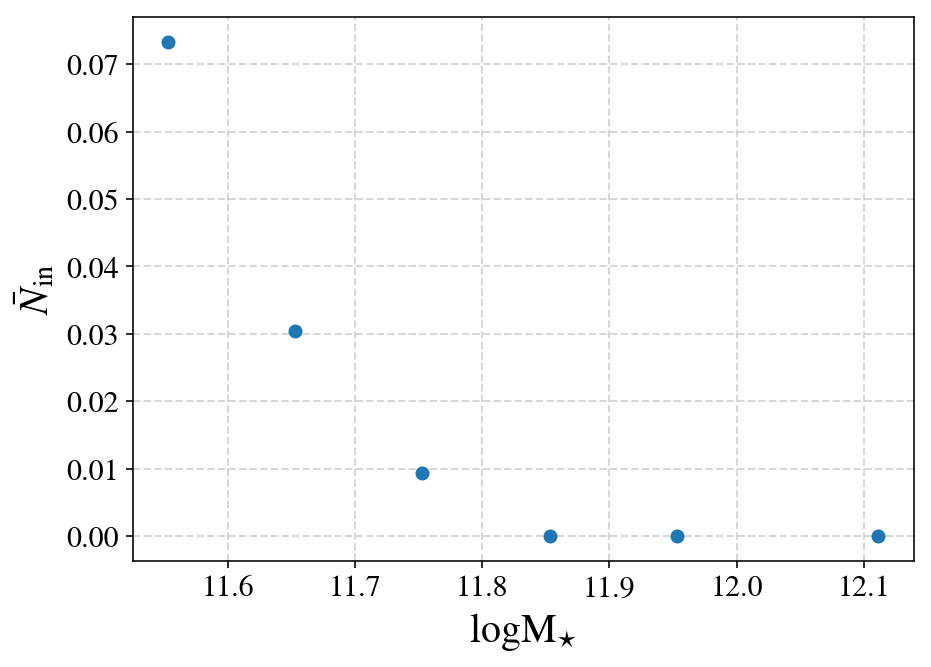

In [32]:
bins = [0,1,2,3,4,5,6,7]
hist_11_5, edges_11_5 = np.histogram(counts[0],bins)
hist_11_6, edges_11_6 = np.histogram(counts[1],bins)
hist_11_7, edges_11_7 = np.histogram(counts[2],bins)
hist_11_8, edges_11_8 = np.histogram(counts[3],bins)
hist_11_9, edges_11_9 = np.histogram(counts[4],bins)
hist_12_0, edges_12_0 = np.histogram(counts[5],bins)


mean_11_5 = (0*hist_11_5[0] + 1*hist_11_5[1] + 2*hist_11_5[2] + 3*hist_11_5[3])/sum(hist_11_5)
mean_11_6 = (0*hist_11_6[0] + 1*hist_11_6[1] + 2*hist_11_6[2])/sum(hist_11_6)
mean_11_7 = (0*hist_11_7[0] + 1*hist_11_7[1] + 2*hist_11_7[2])/sum(hist_11_7)
mean_11_8 = (0*hist_11_8[0] + 1*hist_11_8[1] + 2*hist_11_8[2])/sum(hist_11_8)
mean_11_9 = (0*hist_11_9[0] + 1*hist_11_9[1] + 2*hist_11_9[2])/sum(hist_11_9)
mean_12_0 = (0*hist_12_0[0] + 1*hist_12_0[1] + 2*hist_12_0[2])/sum(hist_12_0)

means = [mean_11_5, mean_11_6, mean_11_7, mean_11_8, mean_11_9, mean_12_0]

err = [np.sqrt(sum(hist_11_5))/sum(hist_11_5),
      np.sqrt(sum(hist_11_6))/sum(hist_11_6),
      np.sqrt(sum(hist_11_7))/sum(hist_11_7),
      np.sqrt(sum(hist_11_8))/sum(hist_11_8),0,0]
#      np.sqrt(sum(hist_11_9))/sum(hist_11_9),
#      np.sqrt(sum(hist_12_0))/sum(hist_12_0),
#      np.sqrt(sum(hist_12_1))/sum(hist_12_1),
#      np.sqrt(sum(hist_12_2))/sum(hist_12_2)]

# where to plot the points. Mean mass in the bin
mass_bins = [11.5,11.6,11.7,11.8,11.9,12.0,12.2]
hist, edges = np.histogram(pdr_use['logm_max'],mass_bins)
mass_mean = np.log10((10**(edges[1:]) + 10**(edges[:-1])) / 2)
mass_mean


fig = plt.figure(figsize = [7,5])
ax1 = fig.add_subplot(111)
ax1.grid(linewidth=1, linestyle='--', alpha=0.5)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)

ax1.set_ylabel(r'$ \bar{N}_{\rm in}$', fontsize = 20)
ax1.set_xlabel(r'$\log \rm M_{\star}$', fontsize = 20)
ax1.errorbar(mass_mean, means, fmt = 'o')

## Now I want to work with randoms. The first thing I'm going to do is set up the table and check that the catalog Song sent is for the correct region.

In [64]:
# path to the data file
random_file = data_pth +'s16a_random_500k.npy'

# read in the array and make a table
randoms = Table(np.load(random_file))
randoms

ra,dec,field,jk,redshift,z
float64,float64,int64,int64,float64,float64
29.932068028235665,-3.990383163553301,5,0,0.0,0.823228405030071
132.71031544050894,1.1812907640265562,1,0,0.0,0.7173560438258898
140.12196091406872,3.240460489530151,1,0,0.0,0.257594664133045
136.49921258499833,-1.0299306731749192,1,0,0.0,0.7246959564215889
237.246892560633,42.47810251960571,4,0,0.0,0.356747536865089
221.91656450744262,0.6307976659972396,2,0,0.0,0.47977608822262463
216.01995830503026,-0.8049424725083352,2,0,0.0,0.6853082039340612
334.04642925504425,1.5125417691335883,6,0,0.0,0.2874827387193755
36.71679133447393,-2.729743420142457,5,0,0.0,0.339125399445356


It looks like the information we actually need here is in the `ra`, `dec`, and `z` columns. In fact, we actually want to replace every value  in the `z` column with a random redshift from our sample. I will write up some quick code to do so.

In [65]:
randoms.remove_columns(['field', 'jk', 'redshift'])
randoms

ra,dec,z
float64,float64,float64
29.932068028235665,-3.990383163553301,0.823228405030071
132.71031544050894,1.1812907640265562,0.7173560438258898
140.12196091406872,3.240460489530151,0.257594664133045
136.49921258499833,-1.0299306731749192,0.7246959564215889
237.246892560633,42.47810251960571,0.356747536865089
221.91656450744262,0.6307976659972396,0.47977608822262463
216.01995830503026,-0.8049424725083352,0.6853082039340612
334.04642925504425,1.5125417691335883,0.2874827387193755
36.71679133447393,-2.729743420142457,0.339125399445356


In [66]:
hsc_sample_z = pdr_use['z_best'] # all sample redshifts
random_redshift_index = np.random.randint(len(hsc_sample_z), size = len(randoms))
randoms['z'] = hsc_sample_z[random_redshift_index]

# Make an index column
randoms['index'] = np.zeros(len(randoms['z']))

for i in range(len(randoms['index'])):
     randoms['index'][i] = i

In [67]:
randoms

ra,dec,z,index
float64,float64,float64,float64
29.932068028235665,-3.990383163553301,0.4345875382423401,0.0
132.71031544050894,1.1812907640265562,0.302480012178421,1.0
140.12196091406872,3.240460489530151,0.25398001074790955,2.0
136.49921258499833,-1.0299306731749192,0.40310001373291016,3.0
237.246892560633,42.47810251960571,0.34345000982284546,4.0
221.91656450744262,0.6307976659972396,0.25751999020576477,5.0
216.01995830503026,-0.8049424725083352,0.28273001313209534,6.0
334.04642925504425,1.5125417691335883,0.42024675011634827,7.0
36.71679133447393,-2.729743420142457,0.4490000009536743,8.0


Looks like that worked! Now to check that the regions line up in `ra` and `dec`

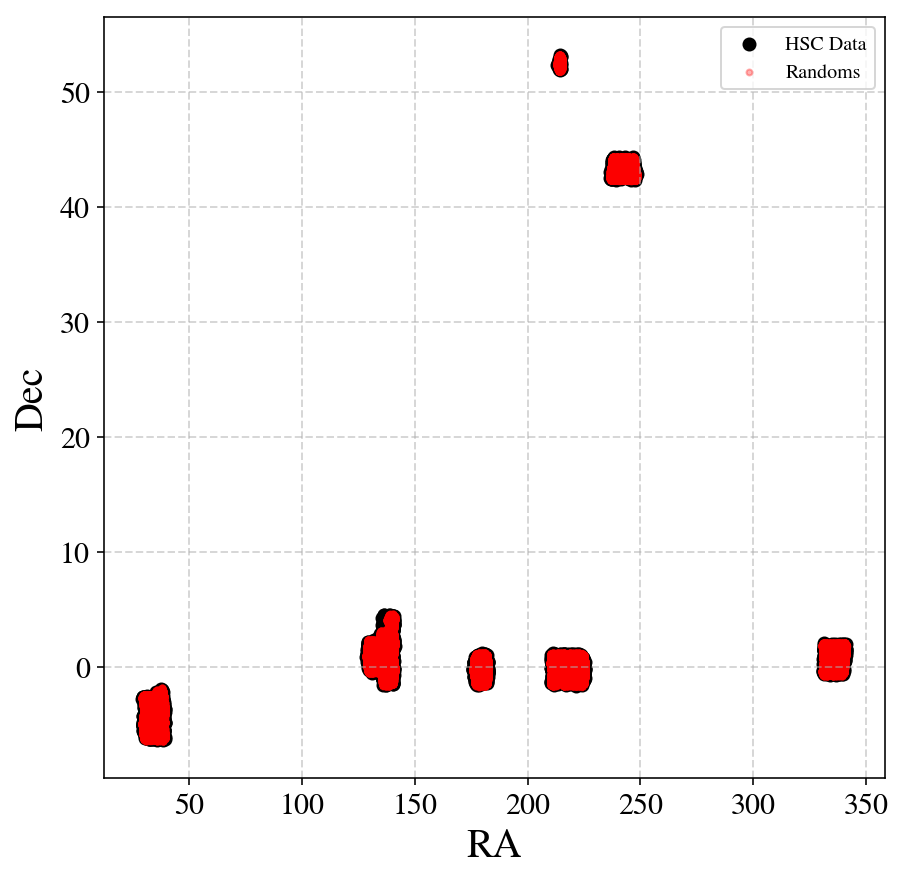

In [68]:
# plot setup
fig = plt.figure(figsize = [7,7])
ax1 = fig.add_subplot(111)
ax1.grid(linewidth=1, linestyle='--', alpha=0.5)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)

ax1.set_ylabel(r'Dec', fontsize = 20)
ax1.set_xlabel(r'RA', fontsize = 20)

ax1.scatter(pdr_use['ra'],pdr_use['dec'] , marker = 'o', color = 'k', label = 'HSC Data')
ax1.scatter(randoms['ra'],randoms['dec'] , marker = '.', color = 'r', alpha = .3, label = 'Randoms')
ax1.legend()

$\Rightarrow$ okay, cool, so that worked! Now I need to perfrom the CiC and cross-correlate with the sample and randoms

So, as I understand it from the screenshot sent by Alexie on 9/26, I can determibe the cross-correlation function from 
$$\xi(R) = \frac{BT}{BR}\frac{n_R}{n_T} - 1$$
In this notation on which Alexie and I agreed, $B$ is the *Bin Sample*, the sample of galaxies in a given bin of mass $M_* = [M_1,M_2]$, $T$ is the *Threshold Sample* with $M_* > M_2$, and $R$ is our catalog of randoms. $\frac{n_R}{n_T}$ is a normalization factor. Now, $BT$ is the result of the CiC above. Now I need to find the CiC between the bins and the randoms, $BR$.

### I've been thinking about this and didn't we want a plot of $M*$ vs $\xi$?

Despite what I started with `corrfunc` below, I will make this plot and we can discuss

## After speaking with Chris, going to try a package called `corrfunc` which will do what I already did, but probably better.

In [32]:
import Corrfunc
from Corrfunc.mocks.DDrppi_mocks import DDrppi_mocks

In [ ]:
# setup params for function
autocorr = False # cross-corr
cosmology = 2 # planck
